# Women in Math and Public Policy Workshop
## Artificial Neural Networks for downscaling temperature data 
Hosted by IPAM and the Rand Corporation in Los Angeles, CA  
January 22 - 25, 2019  

Project Lead: **Cecilia Bitz, UW**  
Team members: **Amanda Back (CSU), Katie Brennan (UW), Oriana Chegwidden (UW), Mimi Hughes (NOAA), Marielle Pinheiro (UC Davis), Kristin Van Abel (RAND)**  

## Goal

Takes the first x number of PCs of temperature calculated from ERAi data and station data from specific locations throughout the west (one at a time) and attempts to downscale the ERAi information to each station. 

In [97]:
import pandas as pd
import xarray as xr 
import numpy as np
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report,confusion_matrix, mean_squared_error

import matplotlib.pyplot as plt

%matplotlib inline

### Functions for loading data: 

In [7]:
def load_all_months_station_data(FILENAME):
    """Takes in file location and returns pandas dataframe containing
       monthly data in order starting from October. 
       
       Inputs: FILENAME = file location (string)
    """
    original_df = pd.read_csv(FILENAME, index_col='year')
    original_df = original_df.drop(columns=['lat','lon'])
    df = pd.Series(original_df.values.ravel(), index=pd.date_range('1979-01', '2018-01', freq='M'))
    df = df.truncate(before='1979-10-01', after='2017-10-01')
    
    return df

In [8]:
def load_station_data_remove_climo(FILENAME):
    """Takes in file location and returns pandas dataframe containing
       monthly data in order starting from October with the monthly
       climotology removed. 
       
       Inputs: FILENAME = file location (string)
    """
    original_df = pd.read_csv(FILENAME, index_col='year')
    original_df = original_df.drop(columns=['lat','lon'])

    # Calculate and remove the time mean from each month: 
    monthly_mean = np.nanmean(original_df,axis=0)
    noclimo_df = original_df - monthly_mean

    df = pd.Series(noclimo_df.values.ravel(), index=pd.date_range('1979-01', '2018-01', freq='M'))
    df = df.truncate(before='1979-10-01', after='2017-10-01')
    
    return df

In [9]:
def load_pcs_regionalmean(FILENAME,N_PCS):
    """Takes in file location and returns pandas dataframe containing
       N_PCS number of principle components. 
       
       Inputs: 
       FILENAME = file location (string)
       N_PCS = number of pcs to include (integer)
    """
    pc_df = pd.read_csv(FILENAME)

    column_names_drop = []
    for j in range(21-N_PCS): 
        column_names_drop = np.append(column_names_drop,'pc'+str(j+N_PCS))
    pcs = pc_df.drop(columns=column_names_drop)
    
    return pcs

## 1. Loading Data: 

### Load station data: 

In [77]:
# Load temperature station data
station_dir = '/glade/work/acback/WPO2019/'
#station_filname_list = ['AFF', 'AKO', 'ALS', 'ASE', 'BKF', 'CEZ', 'CO', 
#                        'COS', 'DRO', 'PUB', 'LHX', 'EGE', 'FCS', 'GUC' 
#                        'STK','TAD', 'GJT', 'HDN', 'MTJ', 'LIC']
station_filename = 'GUC'
filetype = '.csv'

# Load station data: 
# All months:
station_allmo = load_all_months_station_data(station_dir+station_filename+filetype)
station_allmo.head()

# One month:
january_station = station_allmo[station_allmo.index.month==1]

# All months with climotology removed (time mean for each month)
station_allmo_noclimo = load_station_data_remove_climo(station_dir+station_filename+filetype)

In [81]:
station_allmo_noclimo.head()

1979-10-31    0.419088
1979-11-30   -2.465592
1979-12-31   -0.556549
1980-01-31    4.927686
1980-02-29   -0.259550
Freq: M, dtype: float64

Plot station data with climotology removed

Text(0.5,1,'Anomalies of station data without the seasonal cycle')

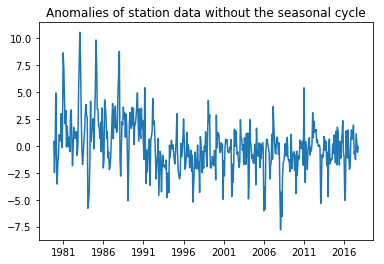

In [79]:
#plt.plot(station_allmo_noclimo[station_allmo_noclimo.index.month==1])
#plt.plot(station_allmo_noclimo[station_allmo_noclimo.index.month==2])
#plt.plot(station_allmo_noclimo[station_allmo_noclimo.index.month==3])
#plt.plot(station_allmo_noclimo[station_allmo_noclimo.index.month==10])
#plt.plot(station_allmo_noclimo[station_allmo_noclimo.index.month==11])
#plt.plot(station_allmo_noclimo[station_allmo_noclimo.index.month==12])
plt.plot(station_allmo_noclimo)
plt.title('Anomalies of station data without the seasonal cycle')

### Load the principle components: 

In [20]:
pc_filename = '/gpfs/fs1/work/bitz/WPO2019/PrepareERAiT2m/T2m_ERAi_inputs_1980to2017WaterYear.csv'

# n_pcs = 21, uses all 20 pcs
n_pcs = 21

pcs = load_pcs_regionalmean(pc_filename,n_pcs)

Here is what the principle component data frame looks like. 

In [80]:
pcs.head()

,RegionalMean,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20
0,1.694821,0.075951,0.023062,0.025244,-0.118883,0.000458,0.118303,-0.289500,0.060122,-0.044694,...,0.076441,-0.067243,-0.171296,0.018175,0.147374,-0.135582,0.003166,-0.033257,0.043155,0.005845
1,-1.257767,0.343518,-0.662072,-0.687407,0.498825,-0.263443,-0.086190,-0.040275,0.035311,-0.043766,...,-0.005928,0.084596,0.124447,-0.152538,0.047829,-0.064945,0.071750,0.029238,0.010311,-0.038833
2,1.861926,1.164131,-0.168992,0.242317,-0.116824,-0.044766,-0.114825,-0.094198,0.064009,0.188652,...,-0.030802,-0.044056,-0.033857,-0.088480,0.004988,0.081493,-0.053102,-0.011069,-0.086880,0.009043
3,-4.957999,-1.908597,-0.443290,-1.091271,1.030761,-0.309235,0.305538,-0.013882,-0.134827,-0.332094,...,0.251689,-0.037797,0.167443,0.040970,-0.116281,0.035978,-0.116634,0.060476,-0.017212,-0.020161
4,-2.427405,-2.252861,-0.486594,0.386229,-1.106951,-0.305325,-0.205418,-0.132703,0.001535,-0.118665,...,0.183689,0.184494,-0.073433,-0.052891,0.003932,0.055020,-0.136504,0.183437,-0.117642,0.089983


### Split data into testing and training: 

Here we split our data into training and testing sets. The index by which to split the data can be specified but is currently set so that 25 years of monthly data is used for training and 13 years of data is used for testing. 

In [41]:
#split_date = 25
split_date = 25*12

X_train = pcs[0:split_date]
X_test = pcs[split_date:pcs.shape[0]]
Y_train = station_allmo_noclimo[0:split_date]
Y_test = station_allmo_noclimo[split_date:pcs.shape[0]]

In [86]:
print('Percent of data used for training: = {}'.format(X_train.shape[0]/X.shape[0]*100)+"%")
print('Percent of data used for testing: = {}'.format(X_test.shape[0]/X.shape[0]*100)+"%")

Percent of data used for training: = 65.64551422319475%
Percent of data used for testing: = 34.13566739606127%


## 2. Data Preprocessing

Here the both the training and testing data is normalized because the neural networks can be sensitive to this type of scaling. We use built-in standardization tools to remove the mean and divide by the standard deviation. 

In [45]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data, appears to subtract mean and normalize by std dev 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

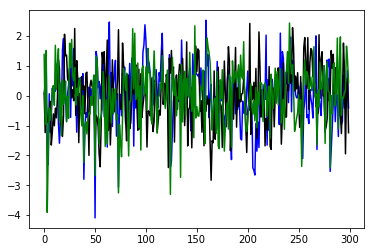

In [48]:
# Plot data after normalization
plt.plot(X_train[:,1], 'b-')
plt.plot(X_train[:,2], 'k-')
plt.plot(X_train[:,0], 'g-')

## 3. Training the model

Now, and instanse of the model is created. We only define the hidden_layer_sizes. You pass this function a tuple consisting of the number of neurons you want at each layer, where the nth entry in the tuple represents the number of neurons in the nth layer of the MLP model. Currently, the number of neurons are the same as the number of features in the data and the max number of iterations is 500.

In [52]:
mlp = MLPRegressor(hidden_layer_sizes=(456,456,456),max_iter=500)

Now the model has been made so we can fit the preprocessed training data to our model. 

#### The next cell does the fit to the training data **once**. 

In [53]:
mlp.fit(X_train,Y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(456, 456, 456), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

#### This next cell does the fit to the training data **iters** times. 

In [ ]:
iters = 100
predictions_100 = np.zeros((iters,X_test.shape[0]))

for it in range(iters):
    mlp.fit(X_train,Y_train)
    predictions_100[it,:] = mlp.predict(X_test)

## 4. Predictions and Evaluation

Now we're ready to make our predictions with the test data!

In [88]:
predictions = mlp.predict(X_test)

In [94]:
print('R^2 for testing data: = {}'.format(mlp.score(X_train,Y_train)))
print('R^2 for training data: = {}'.format(mlp.score(X_test,Y_test)))
print('Hand-calculated R^2 for predictions/station data: = {}'.format(np.corrcoef(predictions, Y_test)[0, 1]**2))

R^2 for testing data: = 0.9999673556838142
R^2 for training data: = -1.7119695388775433
Hand-calculated R^2 for predictions/station data: = 0.008990299206330375


Calculate the mean squared error: 

In [98]:
mean_squared_error(Y_test,predictions)

9.5767597171631

Text(0,0.5,'Tempearture anomalies [$C^\\circ$]')

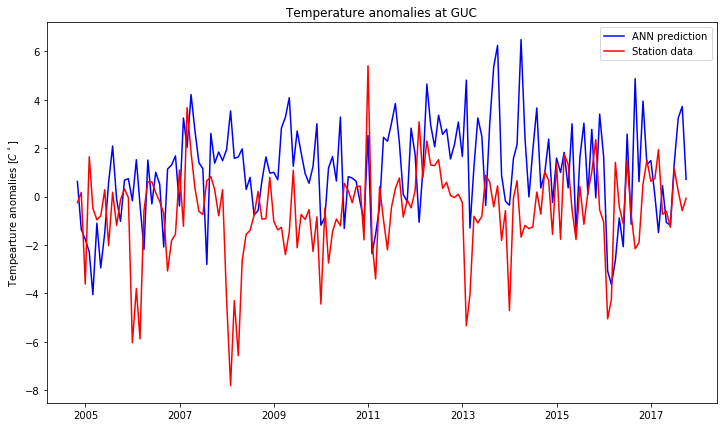

In [90]:
plt.figure(figsize = (12,7))
plt.plot(Y_test.index,predictions,color='b',label = 'ANN prediction')
plt.plot(Y_test,color='r', label = 'Station data')
plt.legend()
plt.title('Temperature anomalies at ' + station_filename)
plt.ylabel('Tempearture anomalies [$C^\circ$]')